# Visual demo of the algorithm

In `01_stats.ipynb`, I used an algorithm which scans for the best path to move from the current condition to an optimal one. Here I show how it works.

In short, the algorithm starts with a model, the conditions of the observation and some convergence parameters.

1. Predict the output from the initial condition.
2. Generate n random points around the point with a fixed radius.
3. From these random samples, filter out those which fall outside the scope of the model (to avoid extrapolation).
4. Predict the output (yield) from the remaining samples.
5. Retain only the best output.
6. If the output is improved, keep it for the next round and shorten the radius by a factor.
7. If the output is not improved, leave it and keep the current state for the next round, then increase the radius by a factor.


In [1]:
library("tidyverse")
library("caret")
library("akima")

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




The dummy dataset is a 2D map of, for instance, two nutrient balances: A and B. I randomly generate these balances through a multivariate normal generator with 300 samples.

In [2]:
set.seed(501426) # random.org
nobs_ex <- 300
bal_ex <- MASS::mvrnorm(n = nobs_ex, mu = c(2, 2), 
                        Sigma = matrix(c(0.015, -0.01,
                                         -0.01, 0.025), 
                                       ncol = 2)) %>% 
  data.frame()

I generate a yield value from these balances, some math to make it only partly linear and randomness.

In [3]:
colnames(bal_ex) <- c("A", "B")
bal_ex$yield <- bal_ex[, 1] * 2 - bal_ex[, 2] * 1 +
  ( 10*cos(bal_ex[, 1]-1.9)-9.5) * 2 +
  ( 10*cos(bal_ex[, 2]-1.9)-9.5) * 1 +
  rnorm(nobs_ex, 0, 0.2)
bal_ex$yield <- bal_ex$yield * 1000 + 1000

In [4]:
bal_map <- interp(bal_ex$A, bal_ex$B, bal_ex$yield, nx = 100, ny = 100) %>%
  interp2xyz() %>%
  data.frame() %>%
  drop_na()

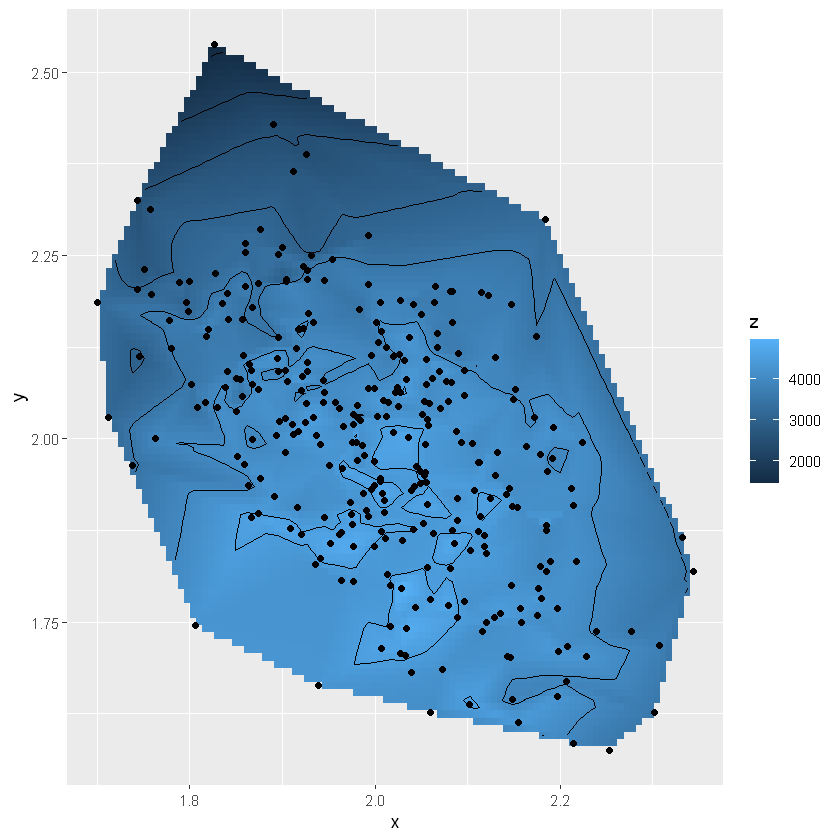

In [5]:
ggplot(bal_map, aes(x = x, y = y)) +
  geom_tile(aes(fill = z)) +
  geom_contour(aes(z = z), colour = "black", binwidth = 500) +
  geom_point(data = bal_ex, aes(x = A, y = B))

A machine learning model can be used to predic the outcome. We usually use a training and testing set, and carefully train the model. But for the sake of this demo, a simple model suffice.

In [6]:
tune_xgb <- expand.grid(
  nrounds = 20,
  max_depth = 2,
  eta = 0.5,
  gamma = 1,
  colsample_bytree = 0.75,
  min_child_weight = 7,
  subsample = 0.95
)

m_fit_ex <- train(yield ~ .,
               data = bal_ex,
               method = "xgbTree",
               tuneGrid = tune_xgb,
               verbose = FALSE
)

Machine learning doesn't raise a flag when it predicts outiside the scope of data. To avoid such extrapolation, the algorithm filters out random samples too far from the data cloud. The Mahalanobis distance is suited for our multivariate environment, and need the center of the scatter and its covariance. Have that, we set a critical distance not to overcome.

In [7]:
bal_mean_ex <- apply(bal_ex %>% select(-yield), 2, mean)
bal_icov_ex <- solve(cov(bal_ex %>% select(-yield)))
crit_dist_ex <- qchisq(p = 0.995, df = length(bal_mean_ex))

I create a grid of points where the model will predict the outcome, then filter out points of the grid too far from the scope of the model.

In [8]:
grid_ex <- expand.grid(A = seq(1.5, 2.5, length = 100),
                       B = seq(1.4, 2.6, length = 100))

maha_ex <- mahalanobis(grid_ex,
                       bal_mean_ex,
                       bal_icov_ex,
                       inverted = TRUE)

grid_ex <- grid_ex %>% 
  filter(maha_ex < crit_dist_ex)

Then I predict the output on the filtered grid.

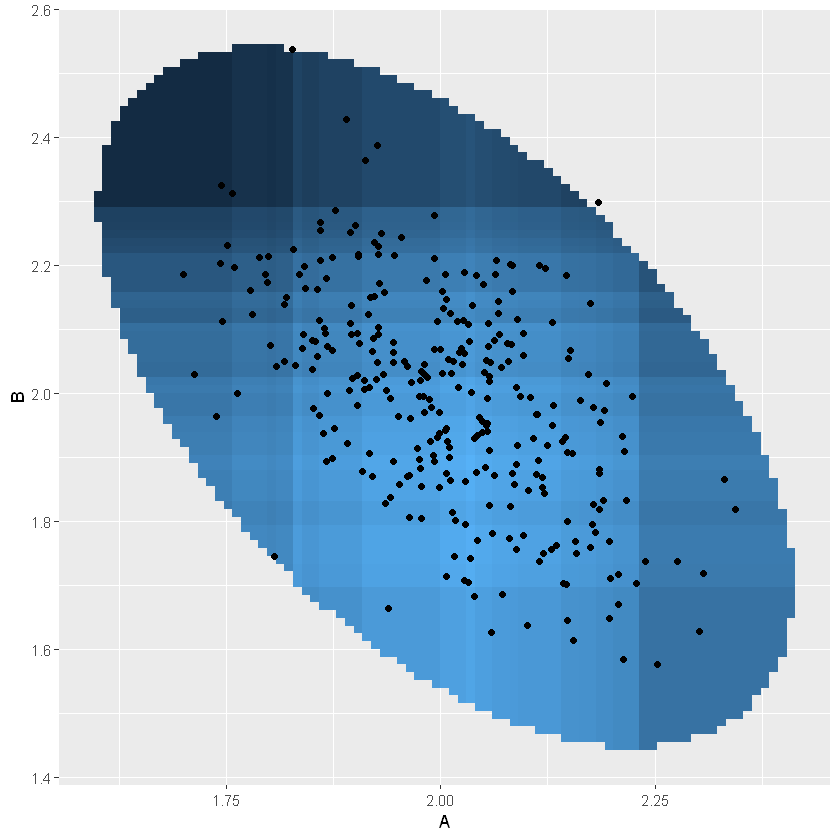

In [9]:
grid_ex$yield <- predict(m_fit_ex, newdata = grid_ex)

ggplot(grid_ex, aes(A, B)) +
  geom_tile(aes(fill = yield), show.legend = FALSE) +
  geom_point(data = bal_ex, aes(x = A, y = B))

This is what a boosted tree looks like. A gaussian process or a neural network would have shown a smoother gradation, but I used a xgboost since this algorithm showed a good balance between biais and variance with blueberry data.

Now, before we launch the algorithm, we specify the initial radius, its increasing / decreasing factor, its limits, the number of samples and the number of iterations.

In [10]:
radius <- c(0.05)
radius_factor <- 1.25
radius_limits <- c(0.01, 0.15)
n_rad <- 500
max_iter <- 50

The `ref_leaf` matrix retains the best ionome to reach at each step. The `ref_yield` is a vector storing the output. I initialize the matrix with an observation, a point to start with, and I initialize the vector with its predicted outcome.

In [11]:
ref_leaf <- matrix(ncol = 2, nrow = max_iter)
ref_yield <- rep(NA, max_iter)

ref_leaf[1, ] <- c(1.75, 2.3)
ref_yield[1] <- predict(
  m_fit_ex,
  newdata = data.frame(A = ref_leaf[1, 1],
                       B = ref_leaf[1, 2])
)

And I launch the algorithm.

In [12]:
for (i in 2:max_iter) {
  offset <- matrix(runif(ncol(ref_leaf) * n_rad, -1, 1), 
                   ncol = ncol(ref_leaf),
                   nrow = n_rad)
  offset <- t(apply(offset, 1, function(x) radius[i-1] * x / sqrt(sum(x^2))))
  leaf_search <- t(apply(offset, 1, function(x) x + ref_leaf[i-1, ] ))
  maha_dist <- mahalanobis(leaf_search, bal_mean_ex, bal_icov_ex, inverted = TRUE)
  leaf_search <- data.frame(leaf_search) %>% filter(maha_dist < crit_dist_ex)
  names(leaf_search) <- c("A", "B")
  yield_stochastic <- predict(
    m_fit_ex,
    newdata = leaf_search
  )
  s
  if(nrow(leaf_search) == 0) { # if no points are generated in the hyper ellipsoid, keep the reference but increase radius
    print(paste("Iteration", i, "- out of the hyperellipsoid."))
    ref_yield[i] <- ref_yield[i-1]
    ref_leaf[i, ] <- ref_leaf[i-1, ]
    # increase the radius
    radius[i] <- radius[i - 1] * radius_factor
    radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
  } else {                   
    if(max(yield_stochastic) > ref_yield[i-1]) {
      ref_yield[i] <- max(yield_stochastic)
      ref_leaf[i, ] <- leaf_search[which.max(yield_stochastic), ] %>% 
        unlist()
      # decrease the radius
      radius[i] <- radius[i - 1] / radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    } else {
      ref_yield[i] <- ref_yield[i-1]
      ref_leaf[i, ] <- ref_leaf[i-1, ]
      # increase the radius
      radius[i] <- radius[i - 1] * radius_factor
      radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
    }
  }
}


The plot would be more elegant as an animation.

In [13]:
n_points_circle <- 50
theta <- seq(0, 2 * pi, length = n_points_circle)
ref_leaf <- data.frame(ref_leaf)
names(ref_leaf) <- c("A", "B")

In [14]:
ait_circle <- list()
ait_circle[[1]] <- ref_leaf[1, ]
ait_circle[[1]]$iteration <- 1
for (i in 2:max_iter) {
  ait_circle[[i]] <- data.frame(A = radius[i-1] * cos(theta) + ref_leaf[i-1, 1],
                                B = radius[i-1] * sin(theta) + ref_leaf[i-1, 2])
  ait_circle[[i]]$iteration <- i
}
ait_circle <- do.call(rbind.data.frame, ait_circle)


In [15]:
ref_leaf$iteration <- 1:nrow(ref_leaf)

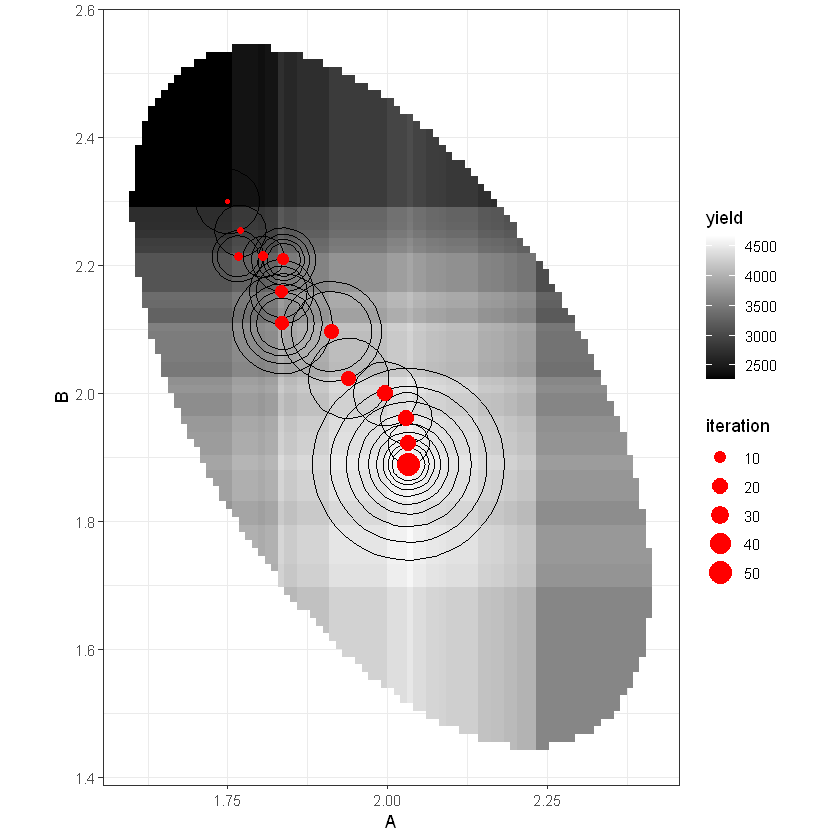

In [31]:
ggplot(grid_ex, aes(A, B)) +
  geom_tile(aes(fill = yield)) +
  geom_path(data = ait_circle, aes(group = iteration)) +
  geom_point(data = ref_leaf, aes(size = iteration), colour = "red") +
  coord_equal() +
  scale_fill_gradient(low = "black", high = "white") +
  theme_bw() +
  ggsave("images/convegence-algo.png", height = 6, width = 6, dpi = 300)

The path of the point can be animated. However, the radius couldn't since a path seems do be difficult to animate. I'm leaving the code here, but it is not executed.

To be able to display the radius, I exported a series of png, then created the gifs with image magick on Windows with `magick -delay 20 *.png -loop 0 worm-anim.gif`.

In [29]:
theta <- seq(0, 2 * pi, length = 200)

for (i in 2:max_iter) {
  ggplot(grid_ex, aes(A, B)) +
    geom_tile(aes(fill = yield), show.legend = FALSE) +
    geom_path(data = ait_circle %>% filter(iteration == i)) +
    geom_point(data = ref_leaf[c(i-1, i), ], colour = "red") +
    scale_fill_gradient(low = "black", high = "white") +
    coord_equal() +
    theme_bw() +
    ggsave(paste0("images/anim/", sprintf("%02d", i), ".png"), height = 4, width = 4, dpi = 120)
}
system("magick -delay 20 images/anim/*.png -loop 0 images/anim/worm-anim.gif")

[1] 0

![](images/anim/worm-anim.gif)

Here is how each compoenent evolutes through iterations.

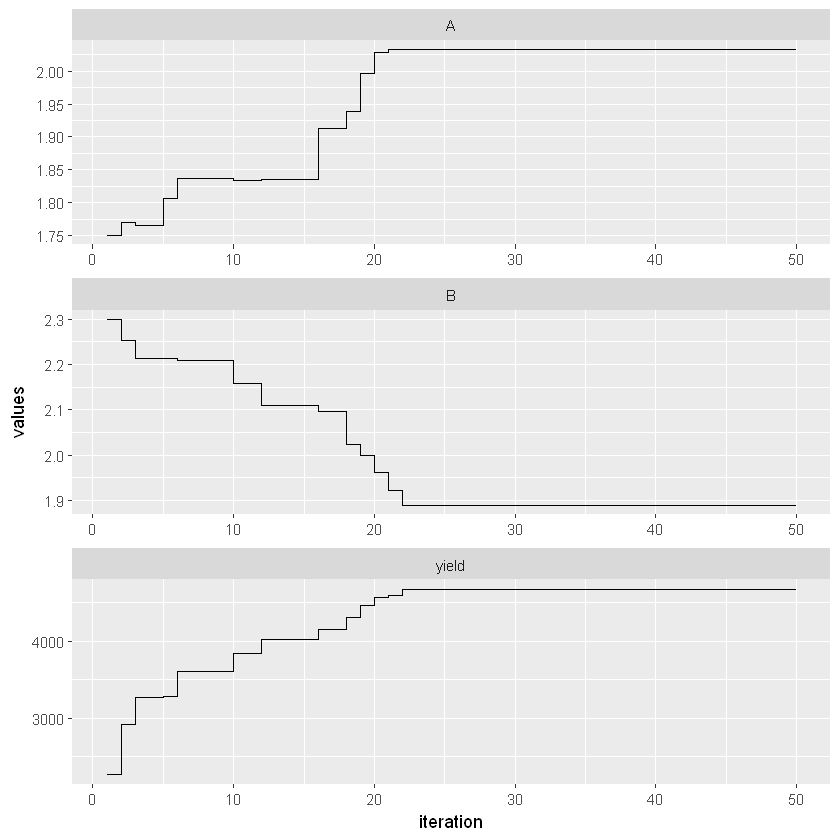

In [19]:
ref_leaf %>% 
  mutate(yield = ref_yield) %>%
  pivot_longer(cols = -iteration, names_to = "variable", values_to = "values") %>%
  ggplot(aes(iteration, values)) +
    facet_wrap(~variable, ncol = 1, scales = "free") +
    geom_step()